In [1]:
import os
from pathlib import Path

while Path.cwd().name.lower() != "aiml25-exam" and "aiml25-exam" in str(Path.cwd()).lower():
    os.chdir("..")  # Move up one directory
print(f"Working directory set to: {Path.cwd()}")

Working directory set to: /Users/isimisi/Documents/GitHub/isimisi/AIML25-Exam


In [2]:
from src.yolo.yolo import Yolo
from ultralytics import YOLO
from src.utils.path import from_root

In [4]:
model = YOLO(from_root("models/yolo-trained.pt"))

yolo = Yolo(model)
yolo.predict(from_root("datasets/test/images/4.png"))


image 1/1 /Users/isimisi/Documents/GitHub/isimisi/AIML25-Exam/datasets/test/images/4.png: 384x640 7 sub-flows, 499.3ms
Speed: 1.1ms preprocess, 499.3ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'sub-flow'}
 obb: None
 orig_img: array([[[248, 245, 243],
         [248, 245, 243],
         [248, 245, 243],
         ...,
         [248, 245, 243],
         [248, 245, 243],
         [248, 245, 243]],
 
        [[248, 245, 243],
         [248, 245, 243],
         [248, 245, 243],
         ...,
         [248, 245, 243],
         [248, 245, 243],
         [248, 245, 243]],
 
        [[248, 245, 243],
         [248, 245, 243],
         [248, 245, 243],
         ...,
         [248, 245, 243],
         [248, 245, 243],
         [248, 245, 243]],
 
        ...,
 
        [[248, 245, 243],
         [248, 245, 243],
         [248, 245, 243],
         ...,
         [248, 245, 243],
         [248, 245, 243],
         [248, 245, 243]],
 
        [[248, 245, 243],
         [248, 245, 243],
         [248, 245, 243],
         ...,
         [248, 2

In [5]:
bboxes = yolo.getBBoxes()
images = yolo.cropImages(bboxes)

# images = images[:3]

print(len(images))

7


In [6]:
from src.edge_detector_llm import EdgeDetectorLLM
from decouple import config

WX_API_KEY = config("WX_API_KEY")
WX_PROJECT_ID = config("WX_PROJECT_ID")
WX_API_URL = "https://us-south.ml.cloud.ibm.com"

model = EdgeDetectorLLM(
    api_key=WX_API_KEY,
    project_id=WX_PROJECT_ID,
    api_url=WX_API_URL,
    model_id="watsonx/meta-llama/llama-3-2-90b-vision-instruct",  
    params={}
)

In [7]:
edges = []

for image in images:
    response = model.invoke(image, found_edges=edges)
    edges.extend(response.answer)

# path = str(from_root("datasets/test/images/4.png"))

# response = model.invoke(path, found_edges=edges)
edges.extend(response.answer)

edges

[{'source': 'Company 1', 'target': 'Owner 1'},
 {'source': 'Owner 1', 'target': 'Fund'},
 {'source': 'Fund', 'target': 'Company 2'},
 {'source': 'Company 3', 'target': 'Owner 3'},
 {'source': 'Company 1', 'target': 'Entity'},
 {'source': 'Owner 3', 'target': 'Entity'},
 {'source': 'Fund 2', 'target': 'Company 3'},
 {'source': 'Company 3', 'target': 'Owner 3'},
 {'source': 'Owner 3', 'target': 'Entity'},
 {'source': 'Entity', 'target': 'Company 1'},
 {'source': 'Fund 2', 'target': 'Company 3'},
 {'source': 'Company 3', 'target': 'Owner 3'},
 {'source': 'Owner', 'target': 'Entity'},
 {'source': 'Owner 3', 'target': 'Company 3'},
 {'source': 'Owner 3', 'target': 'Company 3'}]

In [67]:
response

EdgeResponse(reasoning='Visual analysis provided no new edges to add to the flowchart.', answer=[])

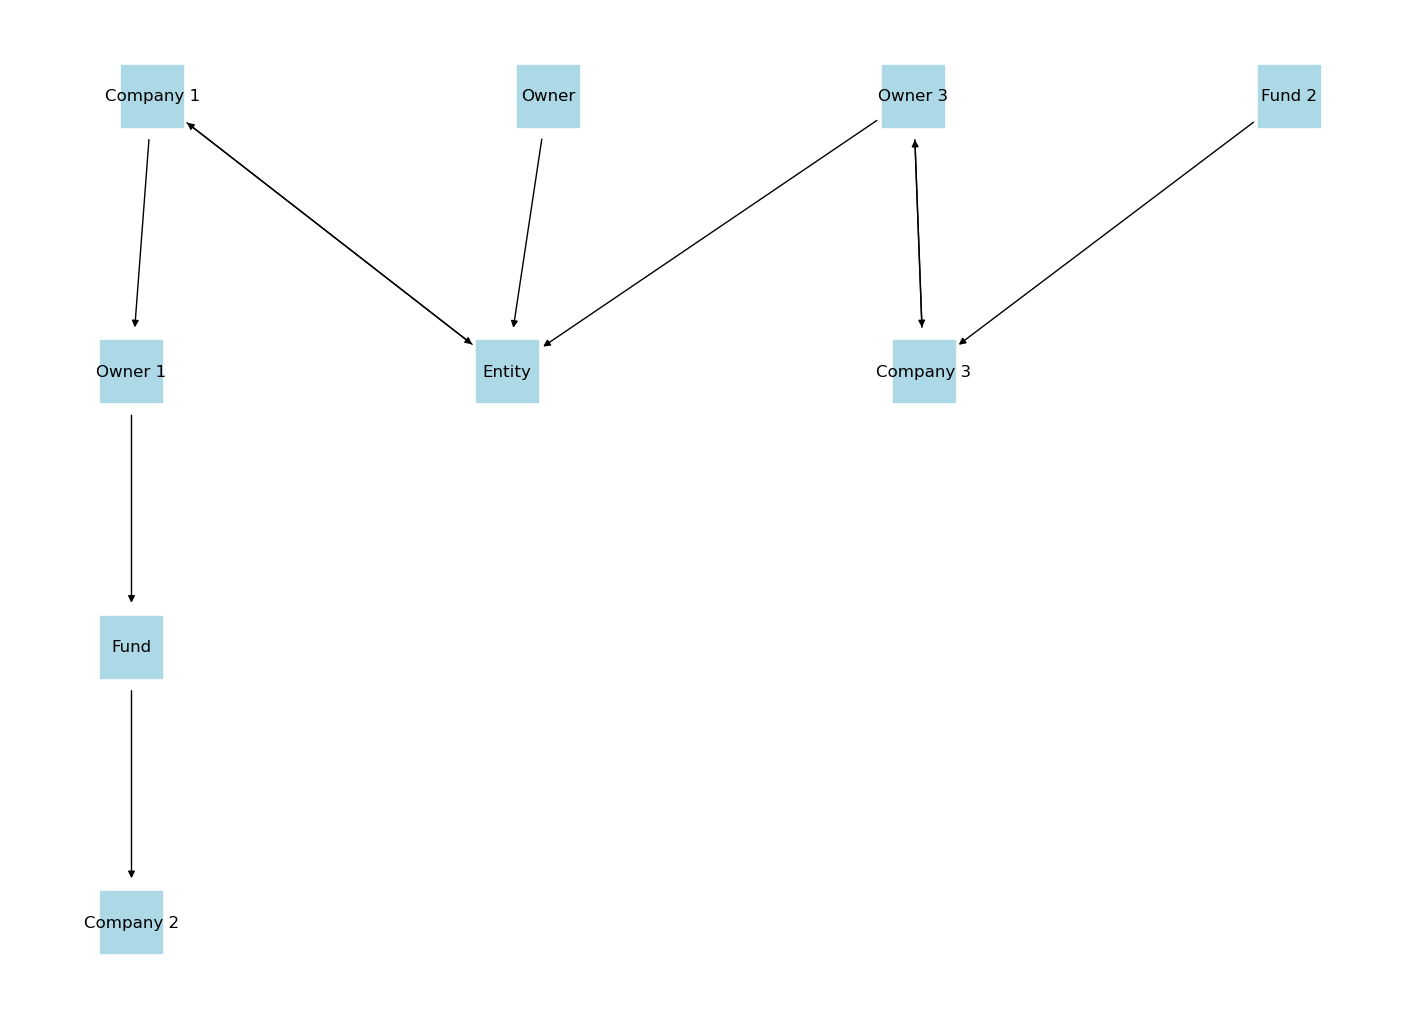

In [8]:
from src.graph_factory import GraphFactory
import matplotlib.pyplot as plt

factory = GraphFactory(edges)

graph = factory.create_graph()

plt.figure(figsize=(14, 10))
factory.plot_graph(graph).show()






In [8]:
for idx, image in enumerate(images):
    image.save(f"tmp/{idx}.png")

In [20]:
factory.edges

[{
   "id": "Owner 3-Entity",
   "source": "Owner 3",
   "target": "Entity"
 },
 {
   "id": "Owner 1-Entity",
   "source": "Owner 1",
   "target": "Entity"
 },
 {
   "id": "Company 3-Fund 2",
   "source": "Company 3",
   "target": "Fund 2"
 },
 {
   "id": "Company 2-Fund 1",
   "source": "Company 2",
   "target": "Fund 1"
 }]

In [9]:
true_edge_factory = GraphFactory([{"source": "Owner 1", "target": "Entity"}, {"source": "Owner 1", "target": "Company 2"}, {"source": "Owner 3", "target": "Company 3"}, {
                                 "source": "Owner 3", "target": "Entity"}, {"source": "Fund 1", "target": "Company 2"}, {"source": "Fund 2", "target": "Company 3"}, {"source": "Entity", "target": "Company 1"}])

true_edge_factory.edges

[{
   "id": "Owner 1-Entity",
   "source": "Owner 1",
   "target": "Entity"
 },
 {
   "id": "Owner 1-Company 2",
   "source": "Owner 1",
   "target": "Company 2"
 },
 {
   "id": "Owner 3-Company 3",
   "source": "Owner 3",
   "target": "Company 3"
 },
 {
   "id": "Owner 3-Entity",
   "source": "Owner 3",
   "target": "Entity"
 },
 {
   "id": "Fund 1-Company 2",
   "source": "Fund 1",
   "target": "Company 2"
 },
 {
   "id": "Fund 2-Company 3",
   "source": "Fund 2",
   "target": "Company 3"
 },
 {
   "id": "Entity-Company 1",
   "source": "Entity",
   "target": "Company 1"
 }]

In [10]:
from src.edge_validator import EdgeValidator

validator = EdgeValidator(true_edge_factory.edges, factory.edges)

validator.validate()

{'true_positives': ['owner 3-company 3',
  'entity-company 1',
  'owner 3-entity',
  'fund 2-company 3'],
 'false_positives': ['fund-company 2',
  'company 3-owner 3',
  'company 1-entity',
  'owner-entity',
  'company 1-owner 1',
  'owner 1-fund'],
 'false_negatives': ['owner 1-entity',
  'fund 1-company 2',
  'owner 1-company 2'],
 'precision': 0.4,
 'recall': 0.5714285714285714,
 'f1_score': 0.47058823529411764}

In [25]:
gpt_edges = [
    {"source": "Owner 3", "target": "Entity"},
    {"source": "Owner 3", "target": "Company 3"},
    {"source": "Owner 1", "target": "Entity"},
    {"source": "Owner 1", "target": "Company 2"},
    {"source": "Entity", "target": "Company 1"},
    {"source": "Fund 2", "target": "Company 3"},
    {"source": "Fund 1", "target": "Company 2"}
  ]

gpt_fac = GraphFactory(gpt_edges)

validator = EdgeValidator(true_edge_factory.edges, gpt_fac.edges)

validator.validate()

{'true_positives': ['Owner 3-Company 3',
  'Fund 2-Company 3',
  'Fund 1-Company 2',
  'Owner 1-Company 2',
  'Entity-Company 1',
  'Owner 1-Entity',
  'Owner 3-Entity'],
 'false_positives': [],
 'false_negatives': [],
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0}

In [ ]:
from src.edge_validator_llm import LLMEdgeValidator

llm_validator = LLMEdgeValidator(api_key=WX_API_KEY,
                                 project_id=WX_PROJECT_ID,
                                 api_url=WX_API_URL,
                                 model_id="watsonx/ibm/granite-3-2-8b-instruct",
                                 params={})

edge_json = llm_validator.get_json_from_file(from_root("datasets/test/json/4.json"))
true_edges = llm_validator.get_edges_from_json(edge_json)

response = llm_validator.invoke(true_edges, factory.edges)


TypeError: LLMEdgeValidator.get_json_from_file() takes 1 positional argument but 2 were given